In [63]:
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
plt.rcParams.update({'font.size': 14})

## 2.1 e) Diagramme de bifurcation

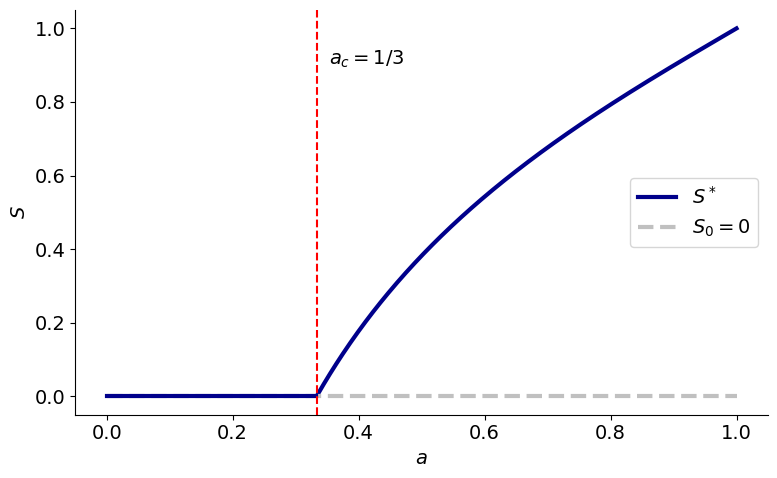

In [252]:
def S(a):
    # On force S = 0 (valeur plancher) en dessous de la valeur critique a_c = 1/3.
    S_vals = np.zeros_like(a)
    # Pour a > 1/3, S est donné par la forme fermée.
    mask = a > 1/3
    u = ((2 - a[mask]) - np.sqrt(a[mask] * (4 - 3 * a[mask]))) / (2 * a[mask])
    S_vals[mask] = 1 - (1 - a[mask]) / (1 - a[mask] * u)
    return S_vals

a = np.linspace(0, 1, 500)
S_vals = S(a)

plt.figure(figsize=(8,5))

# S^* (solution non triviale)
#plt.plot(a[a <= 1/3], S_vals[S_vals <= 1/3], '--', color='silver', label=r"$S^*$", linewidth=3)
plt.plot(a[a > 1/3], S_vals[a > 1/3], color='darkblue', linewidth=3, label=r"$S^*$")

# S_0 = 0 (solution triviale)
plt.plot(a, np.zeros_like(a), '--', color='silver', label=r"$S_0 = 0$", linewidth=3)
plt.plot(a[a <= 1/3], np.zeros_like(a[a <= 1/3]), color='darkblue', linewidth=3)

plt.axvline(1/3, color="red", linestyle="--")#, label=r"$a_c = 1/3$")
plt.text(1/3 + 0.02, 0.9, r"$a_c = 1/3$", fontsize=14, color="black")
plt.xlabel(r"$a$")
plt.ylabel(r"$S$")
plt.legend(loc="center right")
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("fig/diagramme_bifurcation_S.png", dpi=200)
plt.show()


## 2.1 h) Méthode FFT vs prédiction analytique

In [111]:
from sympy import symbols, solve

In [112]:
# Définir les variables
u, a, z = symbols('u a z')

# Définir le polynôme
polynome = u - 2*a*u**2 + a**2*u**3 - z*(1-a)**2

In [113]:
# Cas particulier z = 1
racines_z1 = solve(polynome.subs(z, 1), u)
print("Racines pour z = 1 :", racines_z1)



Racines pour z = 1 : [1, (-a**2 + 2*a - sqrt(-3*a**4 + 4*a**3))/(2*a**2), (-a**2 + 2*a + sqrt(-3*a**4 + 4*a**3))/(2*a**2)]


In [117]:
racines_z1[1].simplify()

(-a**2 + 2*a - sqrt(a**3*(4 - 3*a)))/(2*a**2)

In [154]:
def coeffs_for_polynome(z, a):
    return [a**2, -2*a, 1, -z*(1 - a)**2]

def find_root(coeffs):
    """
    Résout numériquement les racines du polynôme u - 2*a*u**2 + a*u**3 - z*(1-a)**2
    et retourne celle la plus proche de l'origine dans le plan complexe.
    """
    # Coefficients du polynôme u - 2*a*u**2 + a**2*u**3 - z*(1-a)**2
    #     
    # Résoudre les racines avec numpy.roots
    racines = np.roots(coeffs)
    
    # Retenir la racine avec la norme complexe inférieure
    racine_retenue = racines[np.argmin(np.abs(racines))]
    
    return racine_retenue

In [196]:
# Méthode FFT (Annexe D de la thèse) au point fixe.
def G0(z, a): # On met z pour encourager à penser en termes de plan complexe.
    return ((1-a)) / (1 - a*z)

def h_1(z, a):
    return find_root(coeffs_for_polynome(z, a))

def K(z, a): # Équation (1.81) de la thèse. À noter que A(z) = G1(z) (en se fiant à la définition de l'équation (1.75))
    h_1_calc = h_1(z, a)
    return  z * G0(h_1_calc, a)


In [197]:
# Méthode analytique.
def pi_s_fermee(a, s):
    """
    Distribution analytique des petites composantes avec la forme fermée.
    """
    if s == 1: # Cas particulier \pi_1 = 1 - a.
        return 1 - a
    else: # Cas général s >= 2.
        numerator = a**(s - 1) * factorial(3*s - 3) * (1 - a)**(2*s - 1)
        denominator = factorial(s - 1) * factorial(2*s - 1)
        return  numerator / denominator

In [198]:
# Paramètres d'essai.
a = 0.2 # Doit être > a_c = 1/3 pour avoir des petites composantes.
s_max = 20
N = 64  # Nombre de points FFT (doit être > s_max pour satisfaire le théorème de Nyquist-Shannon.)

# A) Méthode analytique.
s_vals = np.arange(1, s_max)
pi_vals = np.zeros_like(s_vals, dtype=np.float64)

for i, s in enumerate(s_vals): # Exctraction des valeurs analytiques.
    pi_vals[i] = pi_s_fermee(a, s) 

# B) Méthode FFT.
r = 1  # Rayon de l'intégrale de contour. En le fixant à 1, on peut l'oublier. Par contre, le facteur r**s ci-dessous est indispensable pour toute autre valeur.  
phi = np.linspace(0, 2*np.pi, N, endpoint=False)
z_points = r * np.exp(1j * phi)
K_points = np.zeros_like(z_points, dtype=np.complex128)

for i,z in enumerate(z_points):
    K_points[i] = K(z, a)

# FFT et extraction des coefficients \eta(s).
eta_full = np.fft.fft(K_points) / N  # Correspond au e^{-i(2 \pi n k/N)} à droite de K(...)
s_ids = np.arange(1, s_max) 
eta_fft = np.real(eta_full[s_ids]) / (r**s_ids)  # Appliquer 1/r^s.

# On normalise pour comparer des pommes avec des pommes.
#alpha = 1- S## np.sum(pi_vals) / np.sum(eta_fft)  # Facteur de normalisation.
eta_fft_norm = eta_fft  # Distribution obtenue par FFT, qu'on normalise par alpha.
pi_vals_norm = pi_vals  # Distribution analytique est déjà normalisée.


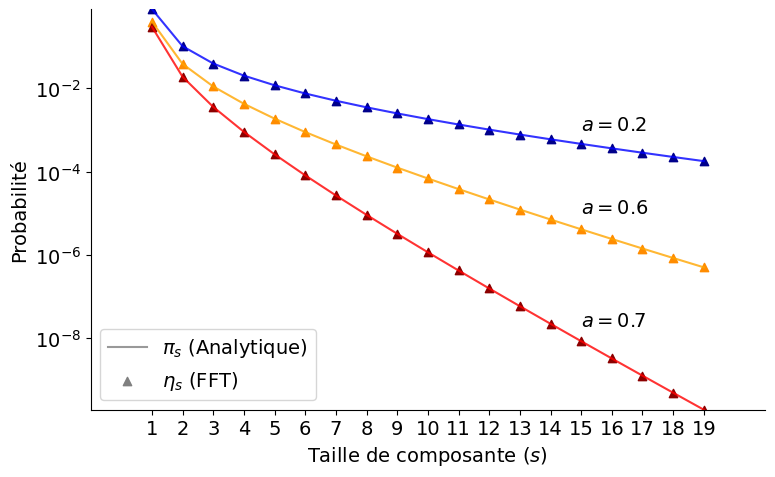

In [254]:
# A) Méthode analytique.
def compute_pi_distribution(a, s_max):
    s_vals = np.arange(1, s_max)
    pi_vals = np.zeros_like(s_vals, dtype=np.float64)

    for i, s in enumerate(s_vals): # Exctraction des valeurs analytiques.
        pi_vals[i] = pi_s_fermee(a, s) 
    
    return s_vals, pi_vals

# B) Méthode FFT.
def compute_eta_distribution(a, s_max, N):
    r = 1  # Rayon de l'intégrale de contour. En le fixant à 1, on peut l'oublier. Par contre, le facteur r**s ci-dessous est indispensable pour toute autre valeur.  
    phi = np.linspace(0, 2*np.pi, N, endpoint=False)
    z_points = r * np.exp(1j * phi)
    K_points = np.zeros_like(z_points, dtype=np.complex128)

    for i,z in enumerate(z_points):
        K_points[i] = K(z, a)

    # FFT et extraction des coefficients \eta(s).
    eta_full = np.fft.fft(K_points) / N  # Correspond au e^{-i(2 \pi n k/N)} à droite de K(...)
    s_ids = np.arange(1, s_max) 
    eta_fft = np.real(eta_full[s_ids]) / (r**s_ids)  # Appliquer 1/r^s.
    
    return eta_fft

# Paramètres d'essai.
a1 = 0.2 # a < a_c
a2 = 0.6 # a > a_c
a3 = 0.7

s_max = 20
N = 64  # Nombre de points FFT (doit être > s_max pour satisfaire le théorème de Nyquist-Shannon.)


eta_fft_1 = compute_eta_distribution(a1, s_max, N)
s_vals,pi_vals_1 = compute_pi_distribution(a1, s_max)

eta_fft_2 = compute_eta_distribution(a2, s_max, N)
s_vals,pi_vals_2 = compute_pi_distribution(a2, s_max)

eta_fft_3 = compute_eta_distribution(a3, s_max, N)
s_vals,pi_vals_3 = compute_pi_distribution(a3, s_max)

x_pos_label = 15
plt.figure(figsize=(8,5))
plt.xticks(s_vals)
plt.plot(s_vals, pi_vals_1, color="blue", alpha=0.8)#,label=r"$\pi_s$ (Analytique)")
plt.scatter(s_vals, eta_fft_1, marker="^", color="darkBlue")#, label=r"$\eta_s$ (FFT)")
plt.text(x_pos_label, 1e-3, rf"$a={a1}$", fontsize=14, color="black")

plt.plot(s_vals, pi_vals_2, color='orange', alpha=0.8)#,label=r"$\pi_s$ (Analytique)")
plt.scatter(s_vals, eta_fft_2, marker="^", color='darkOrange')#, label=r"$\eta_s$ (FFT)")
plt.text(x_pos_label, 1e-5, rf"$a={a2}$", fontsize=14, color="black")

plt.plot(s_vals, pi_vals_3, color='red', alpha=0.8)#, label=r"$\pi_s$ (Analytique)")
plt.scatter(s_vals, eta_fft_3, marker="^", color='darkRed')#, label=r"$\eta_s$ (FFT)")
plt.text(x_pos_label, 10**(-7.7), rf"$a={a3}$", fontsize=14, color="black")


vec_bidon = np.array([0,20])
plt.plot(vec_bidon, vec_bidon*0+1e3, color='gray', alpha=0.8, label=r"$\pi_s$ (Analytique)")
plt.scatter(vec_bidon, vec_bidon*0+1e3, color='gray', marker="^", label=r"$\eta_s$ (FFT)")

plt.xlabel("Taille de composante ($s$)")
plt.ylabel("Probabilité")
plt.legend(loc="lower left")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.ylim(np.min([np.min(pi_vals_1), np.min(pi_vals_2), np.min(pi_vals_3)]),np.max([np.max(pi_vals_1), np.max(pi_vals_2), np.max(pi_vals_3)]))
plt.yscale("log")
plt.savefig("fig/comparaison_distributions_petites_composantes.png", dpi=200)
plt.show()

In [238]:
# Quantification de l'écart MES (erreur quadratique moyenne) entre deux distributions
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mes = mean_squared_error(pi_vals, eta_fft)
print(f"Erreur quadratique moyenne (MES) entre les deux distributions : {mes:.3e}")

Erreur quadratique moyenne (MES) entre les deux distributions : 1.964e-16


In [280]:

a_values = np.linspace(0.01, 0.99, 100)#0.333, 50)
mes_values_stack =  []

N_FFT = [64, 128, 256] # On balaye ce paramètre pour voir son effet.

for N in N_FFT:
    mes_values = []
    for a_test in a_values:
        # Distribution analytique
        s_vals = np.arange(1, s_max)
        pi_vals = np.zeros_like(s_vals, dtype=np.float64)
        eta_vals = np.zeros_like(s_vals, dtype=np.float64)

        s_max = 20
        #N = 64  # Nombre de points FFT (doit être > s_max pour satisfaire le théorème de Nyquist-Shannon.)

        eta_fft = compute_eta_distribution(a_test, s_max, N)
        s_vals,pi_vals = compute_pi_distribution(a_test, s_max)
        eta_fft_norm = eta_fft / np.sum(eta_fft)
        pi_vals_norm = pi_vals / np.sum(pi_vals)

        # MES
        mes = np.mean((pi_vals_norm - eta_fft_norm) ** 2)
        mes_values.append(mes)
    mes_values_stack.append(mes_values) 

mes_values_stack = np.asarray(mes_values_stack)

In [285]:
mes_values_1 = mes_values_stack[0,:]
mes_values_2 = mes_values_stack[1,:]
mes_values_3 = mes_values_stack[2,:]

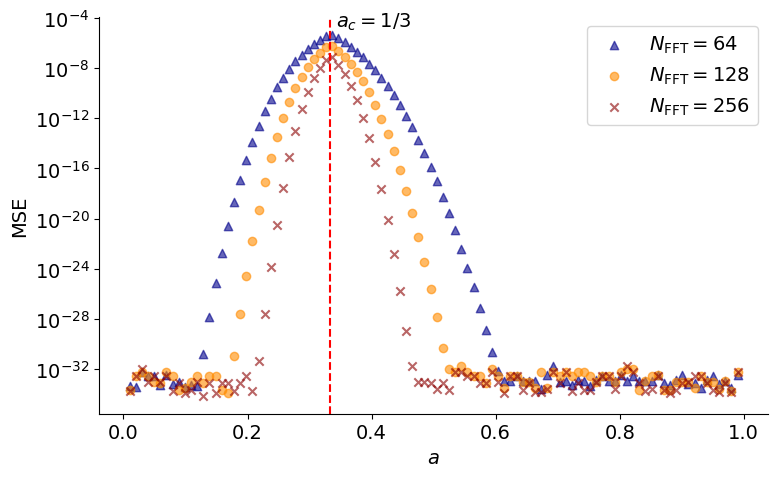

In [309]:
plt.figure(figsize=(8,5))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(a_values, mes_values_1, color="darkBlue", alpha=0.6, marker='^', label=r"$N_{\mathrm{FFT}}=64$")
plt.scatter(a_values, mes_values_2, color="darkOrange", alpha=0.6, marker='o', label=r"$N_{\mathrm{FFT}}=128$")
plt.scatter(a_values, mes_values_3, color="darkRed", alpha=0.6, marker='x',label=r"$N_{\mathrm{FFT}}=256$")
plt.xlabel(r"$a$")
plt.ylabel("MSE")
plt.yscale("log")
plt.axvline(1/3, color="red", linestyle="--")#, label=r"$a_c = 1/3$")
plt.text(1/3+0.01, 10**(-4.7), r"$a_c = 1/3$")
plt.legend()
plt.tight_layout()
plt.savefig("fig/erreur_entre_FFT_et_analytique.png", dpi=200)
plt.show()